## Sentiment analysis with imdb reviews

In this notebook we work with the IMDb dataset, it is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive (1) or negative (0). The dataset contains an even number of positive and negative reviews. Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. We will apply a very simple preprocessing to the textreviews and then train a baseline randomforest on bag of words features. We will compare the results of the bag of word randomforest with a neural network performace where we learn a  dense word-embedding for each word and then classify it to either positive (1) or negative (0). Finally we will use an inception-like architecture with 1D convolutions and globalpooling and see if we can improve the performace. You can test the trained network on new reviews from the internet or by writting your own review for a movie you like or don't like.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [0]:
# Downloading the review and labels, if it does not exist
import urllib
import os
if not os.path.isfile('movie_data.csv'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/kvwi2nlrtk7axn9/movie_data.csv?dl=1",
    "movie_data.csv")

In [0]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')
df[0:5]

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


shuffle the data and extract the first 15000 reviews with the sentiments


In [0]:
df=df.sample(frac=1,random_state=22).reset_index(drop=True)
X = df.loc[0:24999, 'review'].values
y = df.loc[0:24999, 'sentiment'].values

look at one review before we apply some text preprocessing

In [0]:
i=0
print(X[i])
print(y[i])

This is not a new film. It is a re-cut of 1994's "Emmanuelle, Queen of the Galaxy", and it has been significantly truncated. Warning: Many characters appear in the credits that have been cut from the movie!<br /><br />If you want to see this one in its original form, pick up "Queen" - avoid this one at all costs, as the cuts make it even choppier than it was originally.
0


Here we do a very simple preprocessing, no stemming no lemmatization no stopwords removed  
codecredit: https://stackabuse.com/text-classification-with-python-and-scikit-learn/

In [0]:
documents = []

for i in range(0, len(X)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[i]))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Removing html stuff
    document = re.sub("br", '', document)
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Converting to Lowercase
    document = document.lower()
    documents.append(document)

look at the review from before after the text preprocessing

In [0]:
documents[0]

'this is not new film it is re cut of 1994 emmanuelle queen of the galaxy and it has been significantly truncated warning many characters appear in the credits that have been cut from the movie if you want to see this one in its original form pick up queen avoid this one at all costs as the cuts make it even choppier than it was originally '

## RF Baseline

Here we "vectorize" the bag of words. We choose to consider only the 6000 most frequent words and take only words that appear in at least 5 diffrent reviews, furthermore we ignore all words that appear in more than 70% of all reviews. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer(max_features=6000, min_df=5, max_df=0.7)
 
X = vectorizer.fit_transform(documents).toarray()  

In [0]:
print(len(vectorizer.get_feature_names()))#length of all tokens
np.array(vectorizer.get_feature_names()[0:200])#the first 200 tokens

6000


array(['00', '000', '10', '100', '11', '12', '13', '13th', '14', '15',
       '16', '17', '18', '1930', '1930s', '1933', '1939', '1940', '1940s',
       '1945', '1950', '1950s', '1960', '1960s', '1968', '1969', '1970',
       '1970s', '1971', '1972', '1973', '1976', '1977', '1978', '1979',
       '1980', '1980s', '1981', '1983', '1984', '1986', '1987', '1988',
       '1989', '1990', '1993', '1994', '1995', '1996', '1997', '1999',
       '19th', '1st', '20', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '20th', '21st', '22', '23', '24',
       '25', '2nd', '30', '3000', '30s', '35', '3d', '3rd', '40', '40s',
       '45', '50', '50s', '60', '60s', '70', '70s', '75', '80', '80s',
       '90', '90s', '95', '99', 'aaron', 'abandoned', 'abc', 'abilities',
       'ability', 'able', 'aboard', 'about', 'above', 'absence', 'absent',
       'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abusive',
       'abysmal', 'academy', 'accent', 'accents', 'accept',

spliting the bag of words into a train valid and testset

In [0]:
X_train = X[0:10000]
y_train = y[0:10000]
X_val = X[10000:20000]
y_val = y[10000:20000]
X_test = X[20000:25000]
y_test = y[20000:25000]

the data more or less balanced

In [0]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(array([0, 1]), array([4994, 5006]))
(array([0, 1]), array([4965, 5035]))
(array([0, 1]), array([2507, 2493]))
(10000,)
(10000,)
(5000,)


bag of words for the first five reviews (very sparse representation), 5000 observations, with 6000 features


In [0]:
print(X_train[0:5])
print(X_train.shape)

['This is not a new film. It is a re-cut of 1994\'s "Emmanuelle, Queen of the Galaxy", and it has been significantly truncated. Warning: Many characters appear in the credits that have been cut from the movie!<br /><br />If you want to see this one in its original form, pick up "Queen" - avoid this one at all costs, as the cuts make it even choppier than it was originally.'
 'I can only guess that this movie was an experiment that misfired. Years earlier, it would have been moving images accompanied by music. Later, it would have been sound added to silents. Eventually it would have been Technicolor, Cinemascope or Imax. This movie must have been a misguided attempt to introduce a new element to the talking picture. During all the emotional scenes, the character stops in mid dialogue and their inner thoughts are narrated while they gaze off into the distance or appeal to the camera. This interruption is painful at it\'s very least. Imagine these top tier actors trying to look busy whil

let's train a radomforest on the bag of words features of the train set

In [0]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300, random_state=36)  
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=36, verbose=0,
                       warm_start=False)

prediction on the test set with the accuracy and the confusion matrix

In [0]:
y_pred = classifier.predict(X_test)  
print(pd.crosstab(y_test, y_pred,rownames=['true'], colnames=['pred']))
print("Acc = ",np.sum(y_test==y_pred)/len(y_test))

pred     0     1
true            
0     2084   423
1      389  2104
Acc =  0.8376


## Neural network with wordembedding

In [0]:
X_train = documents[0:10000]
y_train = y[0:10000]
X_val = documents[10000:20000]
y_val = y[10000:20000]
X_test = documents[20000:25000]
y_test = y[20000:25000]

In [0]:
X_train[0]

'this is not new film it is re cut of 1994 emmanuelle queen of the galaxy and it has been significantly truncated warning many characters appear in the credits that have been cut from the movie if you want to see this one in its original form pick up queen avoid this one at all costs as the cuts make it even choppier than it was originally '

In the next cell we tokenize all unique words in the reviews and transform them into a sequence of the corresponding integer number of the token that belongs to the word. For example we cound transform "the" into the number 7. Then we take the length of the longest review and we zeropad all other reviews to that length of the longest review, so all reviews have the same length. 

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# fit tokenizer on all reviews
total_reviews = documents
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_reviews) 


# transform tokens to a sequence of integers
X_train_tokens =  tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# max length of all reviews
max_length = max([len(s.split()) for s in total_reviews])
print("longest review:",max_length,"words")

# define vocabulary size (unique words in all reviews)
vocab_size = len(tokenizer.word_index) + 1
print("number of unique words/tokens:",vocab_size)


# zeropad the sequences to have the "same" length 
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

Using TensorFlow backend.


longest review: 2381 words
number of unique words/tokens: 76912


this is how our input for the neural network will look like, just a sequence of integer numbers

In [0]:
X_train_pad[0]

array([ 8,  5, 19, ...,  0,  0,  0], dtype=int32)

all unique tokens with the corresponding number

In [0]:
#print(tokenizer.word_index)

definition of the network with an embedding layer in the input that maps the numbers (words) into vectors of the same size.
architecture inspired by: https://www.tensorflow.org/tutorials/keras/basic_text_classification


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,GlobalAveragePooling1D,Dropout

EMBEDDING_DIM = 30

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=(None)))
model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 30)          2307360   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 2,308,001
Trainable params: 2,308,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_no_dropout=model.fit(X_train_pad, y_train, batch_size=64, epochs=80, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/80
10000/10000 [==============================] - 2s 184us/step - loss: 0.6929 - acc: 0.5013 - val_loss: 0.6920 - val_acc: 0.4984
Epoch 2/80
10000/10000 [==============================] - 1s 136us/step - loss: 0.6897 - acc: 0.5467 - val_loss: 0.6874 - val_acc: 0.5095
Epoch 3/80
10000/10000 [==============================] - 1s 136us/step - loss: 0.6777 - acc: 0.6062 - val_loss: 0.6654 - val_acc: 0.6290
Epoch 4/80
10000/10000 [==============================] - 1s 135us/step - loss: 0.6255 - acc: 0.7253 - val_loss: 0.5934 - val_acc: 0.6984
Epoch 5/80
10000/10000 [==============================] - 1s 133us/step - loss: 0.5236 - acc: 0.8018 - val_loss: 0.4987 - val_acc: 0.8082
Epoch 6/80
10000/10000 [==============================] - 1s 135us/step - loss: 0.4299 - acc: 0.8522 - val_loss: 0.4330 - val_acc: 0.8403
Epoch 7/80
10000/10000 [==============================] - 1s 134us/step - loss: 0.3627 - acc: 0.8722 - val_loss: 0.3862 - 

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,GlobalAveragePooling1D,Dropout

EMBEDDING_DIM = 30

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=(None)))
model.add(GlobalMaxPooling1D())
model.add(GlobalAv
())
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 30)          2307360   
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 30)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 2,308,001
Trainable params: 2,308,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_with_dropout=model.fit(X_train_pad, y_train, batch_size=64, epochs=80, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/80
10000/10000 [==============================] - 3s 291us/step - loss: 0.6919 - acc: 0.5196 - val_loss: 0.6858 - val_acc: 0.7229
Epoch 2/80
10000/10000 [==============================] - 1s 140us/step - loss: 0.6764 - acc: 0.5771 - val_loss: 0.6391 - val_acc: 0.7824
Epoch 3/80
10000/10000 [==============================] - 1s 142us/step - loss: 0.6219 - acc: 0.6593 - val_loss: 0.5337 - val_acc: 0.8013
Epoch 4/80
10000/10000 [==============================] - 1s 143us/step - loss: 0.5543 - acc: 0.7265 - val_loss: 0.4627 - val_acc: 0.8139
Epoch 5/80
10000/10000 [==============================] - 1s 141us/step - loss: 0.5035 - acc: 0.7666 - val_loss: 0.4260 - val_acc: 0.8278
Epoch 6/80
10000/10000 [==============================] - 1s 139us/step - loss: 0.4703 - acc: 0.7956 - val_loss: 0.4034 - val_acc: 0.8373
Epoch 7/80
10000/10000 [==============================] - 1s 141us/step - loss: 0.4286 - acc: 0.8131 - val_loss: 0.3778 - 

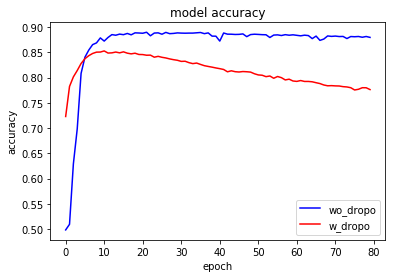

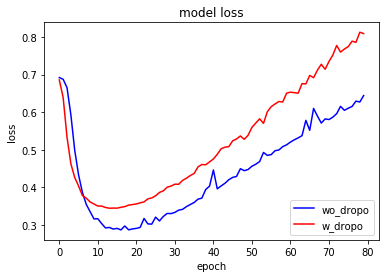

In [0]:
# summarize history 
plt.plot(history_no_dropout.history['val_acc'],color="blue")
plt.plot(history_with_dropout.history['val_acc'],color="red")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wo_dropo', 'w_dropo'], loc='lower right')
plt.show()

plt.plot(history_no_dropout.history['val_loss'],color="blue")
plt.plot(history_with_dropout.history['val_loss'],color="red")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['wo_dropo', 'w_dropo'], loc='lower right')
plt.show()

#### Performace is almost the same around 88% acc, the model with dropout seems to overfit a bit more

In [0]:
y_pred = model.predict_classes(X_test_pad)  
y_pred=y_pred.reshape(len(y_pred))
print(pd.crosstab(y_test, y_pred,rownames=['true'], colnames=['pred']))
print("Acc = ",np.sum(y_test==y_pred)/len(y_test))

pred     0     1
true            
0     2218   289
1      274  2219
Acc =  0.8874


## model with 1d conv after emb

In [0]:
from keras.models import Model
from keras.layers import Input, Activation,Dense, Concatenate, Dropout, Embedding, Conv1D,GlobalMaxPooling1D, Flatten ,MaxPooling1D, GlobalAvgPool1D,BatchNormalization
EMBEDDING_DIM = 30


a = Input(shape=(max_length,))

x = Embedding(vocab_size+ 1, EMBEDDING_DIM)(a)
x1 = Conv1D(filters=20,kernel_size=(3),activation="relu",padding="same")(x)
#x1= Dropout(0.2)(x1)
x2 = Conv1D(filters=20,kernel_size=(5),activation="relu",padding="same")(x)
#x2= Dropout(0.2)(x2)
x3 = Conv1D(filters=20,kernel_size=(7),activation="relu",padding="same")(x)
#x3= Dropout(0.2)(x3)
x4 = Conv1D(filters=20,kernel_size=(9),activation="relu",padding="same")(x)
#x4= Dropout(0.2)(x4)
x5 = Conv1D(filters=20,kernel_size=(11),activation="relu",padding="same")(x)
#x5= Dropout(0.2)(x5)


g1 = GlobalAvgPool1D()(x1)
g2 = GlobalAvgPool1D()(x2)
g3 = GlobalAvgPool1D()(x3)
g4 = GlobalAvgPool1D()(x4)
g5 = GlobalAvgPool1D()(x5)

b1= Concatenate()([g1,g2,g3,g4,g5])
#b1 = Dense(2000)(b1)
#b1 = BatchNormalization()(b1)
#b1 = Activation("relu")(b1)
#b1= Dropout(0.3)(b1)
#b1 = Dense(4000)(b1)
#b1 = BatchNormalization()(b1)
#b1 = Activation("relu")(b1)
#b1= Dropout(0.3)(b1)
out= Dense(1, activation='sigmoid')(b1)
model = Model(inputs=a, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




print('Summary of the built model...')
print(model.summary())


## try with flatten after emb and then dense (not good  ~ 66 val acc )
## try with globalpool after emb and then dense (works alright ~ 80 val acc )

Summary of the built model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2381)         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 2381, 30)     2307390     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 2381, 20)     1820        embedding_19[0][0]               
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 2381, 20)     3020        embedding_19[0][0]               
_______________________________________________________________________________

In [0]:
#global max
history_1dconv_inception_no_fc_part_no_dropout=model.fit(X_train_pad, y_train, batch_size=64, epochs=5, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 7s 663us/step - loss: 0.6414 - acc: 0.6819 - val_loss: 0.4991 - val_acc: 0.7901
Epoch 2/5
10000/10000 [==============================] - 5s 485us/step - loss: 0.3719 - acc: 0.8428 - val_loss: 0.3401 - val_acc: 0.8541
Epoch 3/5
10000/10000 [==============================] - 5s 490us/step - loss: 0.2046 - acc: 0.9277 - val_loss: 0.3092 - val_acc: 0.8684
Epoch 4/5
10000/10000 [==============================] - 5s 493us/step - loss: 0.0946 - acc: 0.9739 - val_loss: 0.3239 - val_acc: 0.8655
Epoch 5/5
10000/10000 [==============================] - 5s 493us/step - loss: 0.0372 - acc: 0.9938 - val_loss: 0.3556 - val_acc: 0.8654


In [0]:
#global ave
history_1dconv_inception_no_fc_part_no_dropout=model.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 7s 693us/step - loss: 0.6771 - acc: 0.6129 - val_loss: 0.6187 - val_acc: 0.7738
Epoch 2/10
10000/10000 [==============================] - 5s 472us/step - loss: 0.4676 - acc: 0.8478 - val_loss: 0.3835 - val_acc: 0.8626
Epoch 3/10
10000/10000 [==============================] - 5s 473us/step - loss: 0.2703 - acc: 0.9153 - val_loss: 0.3056 - val_acc: 0.8854
Epoch 4/10
10000/10000 [==============================] - 5s 475us/step - loss: 0.1764 - acc: 0.9480 - val_loss: 0.2858 - val_acc: 0.8861
Epoch 5/10
10000/10000 [==============================] - 5s 476us/step - loss: 0.1207 - acc: 0.9652 - val_loss: 0.2810 - val_acc: 0.8917
Epoch 6/10
10000/10000 [==============================] - 5s 478us/step - loss: 0.0839 - acc: 0.9798 - val_loss: 0.2872 - val_acc: 0.8898
Epoch 7/10
10000/10000 [==============================] - 5s 476us/step - loss: 0.0588 - acc: 0.9878 - val_loss: 0.2966 - 

In [0]:
from keras.models import Model
from keras.layers import Input, Activation,Dense,CuDNNLSTM, Concatenate, Dropout, Embedding, Conv1D,GlobalMaxPooling1D, Flatten ,MaxPooling1D, GlobalAvgPool1D,BatchNormalization
EMBEDDING_DIM = 30


a = Input(shape=(max_length,))

x = Embedding(vocab_size+ 1, EMBEDDING_DIM)(a)
#x1 = Conv1D(filters=20,kernel_size=(3),activation="relu",padding="same")(x)
##x1= Dropout(0.2)(x1)
#x2 = Conv1D(filters=20,kernel_size=(5),activation="relu",padding="same")(x)
##x2= Dropout(0.2)(x2)
#x3 = Conv1D(filters=20,kernel_size=(7),activation="relu",padding="same")(x)
##x3= Dropout(0.2)(x3)
#x4 = Conv1D(filters=20,kernel_size=(9),activation="relu",padding="same")(x)
##x4= Dropout(0.2)(x4)
#x5 = Conv1D(filters=20,kernel_size=(11),activation="relu",padding="same")(x)
##x5= Dropout(0.2)(x5)
#
#
#g1 = GlobalMaxPooling1D()(x1)
#g2 = GlobalMaxPooling1D()(x2)
#g3 = GlobalMaxPooling1D()(x3)
#g4 = GlobalMaxPooling1D()(x4)
#g5 = GlobalMaxPooling1D()(x5)
#
#b1= Concatenate()([g1,g2,g3,g4,g5])
#b1 = Dense(2000)(b1)
#b1 = BatchNormalization()(b1)
#b1 = Activation("relu")(b1)
#b1= Dropout(0.3)(b1)
#b1 = Dense(4000)(b1)
#b1 = BatchNormalization()(b1)
#b1 = Activation("relu")(b1)
#b1= Dropout(0.3)(b1)

x1 = CuDNNLSTM(20)(x)



out= Dense(1, activation='sigmoid')(x1)
model = Model(inputs=a, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




print('Summary of the built model...')
print(model.summary())


## try with flatten after emb and then dense (not good  ~ 66 val acc )
## try with globalpool after emb and then dense (works alright ~ 80 val acc )

W0619 12:59:38.564084 139948565362560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 12:59:38.589675 139948565362560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 12:59:38.596537 139948565362560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 12:59:39.959272 139948565362560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0619 12:59:39.979807 139948565362560 deprecation_wrappe

Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2381)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2381, 30)          2307390   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,311,571
Trainable params: 2,311,571
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history_1dconv_inception_no_fc_part_no_dropout=model.fit(X_train_pad, y_train, batch_size=64, epochs=80, validation_data=(X_val_pad, y_val), verbose=1)

W0619 12:59:40.292163 139948565362560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10000 samples, validate on 10000 samples
Epoch 1/80
10000/10000 [==============================] - 23s 2ms/step - loss: 0.6935 - acc: 0.4974 - val_loss: 0.6933 - val_acc: 0.5035
Epoch 2/80
10000/10000 [==============================] - 21s 2ms/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6934 - val_acc: 0.5035
Epoch 3/80
10000/10000 [==============================] - 21s 2ms/step - loss: 0.6933 - acc: 0.4970 - val_loss: 0.6933 - val_acc: 0.4965
Epoch 4/80
10000/10000 [==============================] - 21s 2ms/step - loss: 0.6933 - acc: 0.4930 - val_loss: 0.6931 - val_acc: 0.5035
Epoch 5/80
10000/10000 [==============================] - 21s 2ms/step - loss: 0.6932 - acc: 0.4975 - val_loss: 0.6932 - val_acc: 0.4965
Epoch 6/80
10000/10000 [==============================] - 21s 2ms/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6933 - val_acc: 0.4965
Epoch 7/80
 5440/10000 [===============>..............] - ETA: 6s - loss: 0.6931 - acc: 0.5088

KeyboardInterrupt: ignored

### emb and attention

In [0]:
from keras.models import Model
from keras.layers import Input, Activation,Dense,CuDNNLSTM,RepeatVector,Permute,multiply,Lambda, Concatenate, Dropout, Embedding, Conv1D,GlobalMaxPooling1D, Flatten ,MaxPooling1D, GlobalAvgPool1D,BatchNormalization
from keras import backend as K
EMBEDDING_DIM = 30


a = Input(shape=(max_length,))

x = Embedding(vocab_size+ 1, EMBEDDING_DIM)(a)
attention = Dense(10, activation='tanh')(x) 
attention = Dense(1, activation='tanh')(attention) 
attention = Flatten()(attention)
attention_1 = Activation('softmax')(attention)
attention = RepeatVector(30)(attention_1)
attention = Permute([2, 1])(attention)

sent_representation = multiply([x, attention])
sent_representation_1 = Lambda(lambda xin: K.sum(xin, axis=-1))(sent_representation)
#sent_representation = Dense(10, activation='relu')(sent_representation)
#sent_representation = Flatten()(sent_representation)

sent_representation_2 = Dropout(0.5)(sent_representation_1)



out= Dense(1, activation='sigmoid')(sent_representation_2)
model = Model(inputs=a, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




print('Summary of the built model...')
print(model.summary())


## try with flatten after emb and then dense (not good  ~ 66 val acc )
## try with globalpool after emb and then dense (works alright ~ 80 val acc )

Summary of the built model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 2381)         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 2381, 30)     2307390     input_20[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 2381, 10)     310         embedding_20[0][0]               
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 2381, 1)      11          dense_38[0][0]                   
_______________________________________________________________________________

In [0]:
#witn tanh
history_attention=model.fit(X_train_pad, y_train, batch_size=64, epochs=80, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/80
10000/10000 [==============================] - 3s 313us/step - loss: 0.6932 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5035
Epoch 2/80
10000/10000 [==============================] - 2s 200us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5035
Epoch 3/80
10000/10000 [==============================] - 2s 199us/step - loss: 0.6924 - acc: 0.5518 - val_loss: 0.6894 - val_acc: 0.7035
Epoch 4/80
10000/10000 [==============================] - 2s 197us/step - loss: 0.6778 - acc: 0.7247 - val_loss: 0.6658 - val_acc: 0.7542
Epoch 5/80
10000/10000 [==============================] - 2s 198us/step - loss: 0.6439 - acc: 0.7694 - val_loss: 0.6323 - val_acc: 0.7622
Epoch 6/80
10000/10000 [==============================] - 2s 202us/step - loss: 0.6061 - acc: 0.7828 - val_loss: 0.5987 - val_acc: 0.7800
Epoch 7/80
10000/10000 [==============================] - 2s 201us/step - loss: 0.5709 - acc: 0.7883 - val_loss: 0.5688 - 

In [0]:
#with relu does not work!
#history_attention=model.fit(X_train_pad, y_train, batch_size=64, epochs=120, validation_data=(X_val_pad, y_val), verbose=1)

Train on 10000 samples, validate on 10000 samples
Epoch 1/120
10000/10000 [==============================] - 2s 180us/step - loss: 0.0851 - acc: 0.9836 - val_loss: 0.2867 - val_acc: 0.8824
Epoch 2/120
10000/10000 [==============================] - 2s 171us/step - loss: 0.0833 - acc: 0.9846 - val_loss: 0.2874 - val_acc: 0.8818
Epoch 3/120
10000/10000 [==============================] - 2s 167us/step - loss: 0.0815 - acc: 0.9846 - val_loss: 0.2870 - val_acc: 0.8828
Epoch 4/120
10000/10000 [==============================] - 2s 169us/step - loss: 0.0797 - acc: 0.9852 - val_loss: 0.2868 - val_acc: 0.8831
Epoch 5/120
10000/10000 [==============================] - 2s 167us/step - loss: 0.0780 - acc: 0.9857 - val_loss: 0.2878 - val_acc: 0.8817
Epoch 6/120
10000/10000 [==============================] - 2s 168us/step - loss: 0.0763 - acc: 0.9858 - val_loss: 0.2871 - val_acc: 0.8830
Epoch 7/120
10000/10000 [==============================] - 2s 169us/step - loss: 0.0745 - acc: 0.9873 - val_loss: 0.

KeyboardInterrupt: ignored

In [0]:
y_pred = (model.predict(X_test_pad)>0.5)*1
y_pred=y_pred.reshape(len(y_pred))
print(pd.crosstab(y_test, y_pred,rownames=['true'], colnames=['pred']))
print("Acc = ",np.sum(y_test==y_pred)/len(y_test))

pred     0     1
true            
0     2234   273
1      263  2230
Acc =  0.8928


In [0]:
X[5]

"Only watched this to see Joe Morton in an early role and honestly wished I hadn't bothered, he can and has since, done much better than this crap. Cannot understand why anyone finds this kind of stupidity funny but each to his own; it is an absolute mess and not funny in the least. No wait, ONE line only was funny, where Mr Kent (Joe) and his family are having dinner with this nut job as he's been invited for dinner (Lord alone knows why). Pest to Mr Kent: You know what it's like dog, you've been there Mrs Kent: Not lately, Joe's expression was funny but that's it one line does not make a great comedy and this tat is so far away from being funny it should be consigned to the nearest trash cart, it's only good enough for that. Joe Morton - glad to see you don't appear in rubbish like this anymore; you are far superior and a great great actor."

In [0]:
len(X[5])

853

In [0]:
model_attention_weights=Model(inputs=a, outputs=attention_1)


In [0]:
weights=model_attention_weights.predict(X_train_pad)

In [0]:
print(model.predict(X_train_pad[5:6]))
print(y[5])

[[0.05689497]]
0


In [0]:
weights.shape

(10000, 2381)

In [0]:
weights[5]

array([0.00254924, 0.00254924, 0.00034501, ..., 0.000345  , 0.000345  ,
       0.000345  ], dtype=float32)

(array([2300.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   81.]),
 array([0.000345  , 0.00045521, 0.00056543, 0.00067564, 0.00078585,
        0.00089606, 0.00100627, 0.00111648, 0.0012267 , 0.00133691,
        0.00144712, 0.00155733, 0.00166754, 0.00177775, 0.00188797,
        0.00199818, 0.00210839, 0.0022186 , 0.00232881, 0.00243902,
        0.00254924], dtype=float32),
 <a list of 20 Patch objects>)

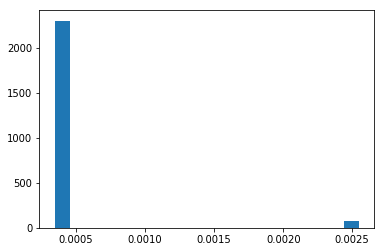

In [0]:
plt.hist(weights[5],bins=20)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 853.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-4.9965501e-01, -4.4965500e-01, -3.9965498e-01, -3.4965500e-01,
        -2.9965499e-01, -2.4965499e-01, -1.9965500e-01, -1.4965500e-01,
        -9.9654995e-02, -4.9654994e-02,  3.4500423e-04,  5.0345004e-02,
         1.0034500e-01,  1.5034500e-01,  2.0034501e-01,  2.5034499e-01,
         3.0034500e-01,  3.5034502e-01,  4.0034500e-01,  4.5034501e-01,
         5.0034499e-01], dtype=float32),
 <a list of 20 Patch objects>)

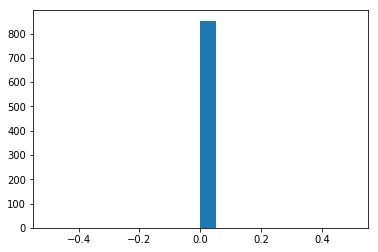

In [0]:
plt.hist(weights[5][-len(X[5]):],bins=20)

In [0]:
np.unique(weights[5][-len(X[5]):])

array([0.000345], dtype=float32)

prediction on the test set with the accuracy and the confusion matrix. Are we better than the RF baseline?


### We need to go deeper! 
Write your own review or test the model on some reviews of Inception or some other movie, note that we can use an arbitrary length for the review.  
Visit: https://www.imdb.com/title/tt1375666/reviews?ref_=tt_ov_rt  
remeber 0 is negative and 1 is postive

In [0]:
#paste new reviews here in the sample list
sample=list(["Inception is truly one of a kind. A concept which has long gestated in Christopher Nolan's mind, his eye for drama mixed with his large scale sensibilities ring true in Blockbuster season making Inception a true original in the sea of reboots, remakes and sequels.To try and explain Inceptions many plot twists and incredibly intelligent arcs, would be a foolish task. As Nolan himself has been reluctant to. The best way to approach the film would be with an open mind, if you are prepared to be taken on a ride of a lifetime, then trust that you 100% will. If Avatar was a seminal film in technology (although coming out as a rather poor film, in my opinion), then Inception is seminal in it's storytelling. With a 148 minute running time, you would expect a lot to take place, but what you wouldn't expect is the pace of it all. I did not think at one time in the film about how long was left. I was simply blown away by the depth in every single part of the film. If my enthusiasm for the storytelling aspect of the film has left you worried about the spectacle, then don't worry. They are, as hinted in the trailer, incredible, looking real and unbelievable simultaneously. The most pleasing thing about the action set pieces, is that they are genuinely used to illustrate the story, rather than to blow stuff up a la Michael Bay. With this complex movie in it's high concept, a stellar cast is needed. And Nolan as always, delivers with just that. This is vintage DiCaprio, perhaps only equalled in The Aviator, which is even more impressive as his role as Cobb in Inception is not a showy one, needing DiCaprio to be the constant at the centre of the film. And he pulls off Cobb's emotional contradictions sublimely. The rest of the cast members all shine in parts of the films, Cillian Murphy shows off his usually non-existent tender side, Gordon-Levitt bottles his usual charm for his confidently reserved turn as the reliable Arthur, Watanabe is devilish as the seemingly ambiguous Saito, Page shows why she's the next big female star and Tom Hardy revels in being the comic relief of the film compared to his recent turns as decidedly psychopathic characters. Overall, Nolan has indeed surpassed himself. He has created a world as expansive as his Gotham, a plot dwarfing the intricacies of Memento and one which blows The Prestige's cinematic reveal out of the water. This is truly unmissable cinema. Revel in it, we've still got to wait a whole two years before Batman 3.",
             "Based on reviews I was hoping this was a different American film in the sense that it will have substance, subtlety and that it will make me think. It did not, it did not and it did not again. It is your typical Hollywood flick with car chases, shooting galore, explosions, fistfights, pretty boys and girls - the whole nine yards to sell tickets to the ADHD generation of teenagers. I gave it 3 stars - instead of just 2 - because the special effects are absolutely astonishing. This film wishes to be clever but really is not and does not make a lot of sense either. It reminded me of the teachers/professors who were confusing on purpose in order to make us believe they are smarter than we were."])
sample_tokens=tokenizer.texts_to_sequences(sample)
#print(np.array(sample_tokens))
print(model.predict(np.array(sample_tokens[0:1])))
print(model.predict(np.array(sample_tokens[1:2])))

ValueError: ignored

### Optional: Neural network with wordembedding (inception like) with Keras functional api  

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Dropout, Embedding, Conv1D,GlobalMaxPooling1D,GlobalAveragePooling1D
EMBEDDING_DIM = 30


a = Input(shape=(max_length,))
x = Embedding(vocab_size, EMBEDDING_DIM)(a)
x1 = Conv1D(filters=50,kernel_size=(3),activation="relu",padding="same")(x)
x2 = Conv1D(filters=50,kernel_size=(5),activation="relu",padding="same")(x)
x3 = Conv1D(filters=50,kernel_size=(7),activation="relu",padding="same")(x)

g1 = GlobalAveragePooling1D()(x1)
g2 = GlobalAveragePooling1D()(x2)
g3 = GlobalAveragePooling1D()(x3)
conc= Concatenate()([g1,g2,g3])
conc = Dropout(0.3)(conc)
conc = Dense(50, activation='relu')(conc)
conc = Dropout(0.3)(conc)
out= Dense(1, activation='sigmoid')(conc)
model = Model(inputs=a, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2381)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 2381, 30)     1868910     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2381, 50)     4550        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2381, 50)     7550        embedding_2[0][0]                
__________________________

In [0]:
history=model.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_data=(X_val_pad, y_val), verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 134s 27ms/step - loss: 0.6932 - acc: 0.5112 - val_loss: 0.6917 - val_acc: 0.5066
Epoch 2/10
5000/5000 [==============================] - 134s 27ms/step - loss: 0.6681 - acc: 0.6152 - val_loss: 0.6030 - val_acc: 0.7400
Epoch 3/10
5000/5000 [==============================] - 136s 27ms/step - loss: 0.4087 - acc: 0.8516 - val_loss: 0.3498 - val_acc: 0.8606
Epoch 4/10
5000/5000 [==============================] - 131s 26ms/step - loss: 0.1911 - acc: 0.9340 - val_loss: 0.3343 - val_acc: 0.8676
Epoch 5/10
5000/5000 [==============================] - 137s 27ms/step - loss: 0.1122 - acc: 0.9638 - val_loss: 0.3568 - val_acc: 0.8668
Epoch 6/10
5000/5000 [==============================] - 135s 27ms/step - loss: 0.0660 - acc: 0.9808 - val_loss: 0.3933 - val_acc: 0.8650
Epoch 7/10
5000/5000 [==============================] - 134s 27ms/step - loss: 0.0432 - acc: 0.9896 - val_loss: 0.4086 - val_acc: 

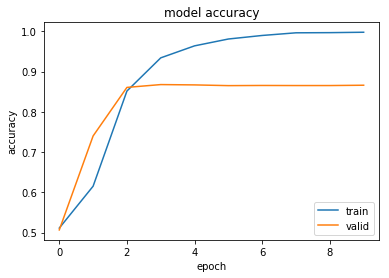

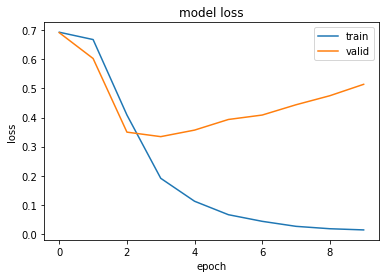

In [0]:
# summarize history 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
y_pred = model.predict(X_test_pad)  
y_pred=np.reshape(np.round(y_pred,0),(len(y_pred)))
print(pd.crosstab(y_test, y_pred,rownames=['true'], colnames=['pred']))
print("Acc = ",np.sum(y_test==y_pred)/len(y_test))

pred   0.0   1.0
true            
0     2178   233
1      371  2218
Acc =  0.8792
